In [ ]:
!pip install mne
!pip install mnelab
!pip install pyxdf
!pip install asrpy
!pip install mne_icalabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.3/513.3 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.5/82.5 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 MB 7.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 38.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import mne
import pyxdf
from mnelab.io import read_raw
import random
random.seed(187964418554)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Jun 14 12:32:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# MNE cuda
mne.utils.set_config('MNE_USE_CUDA', 'true')
mne.cuda.init_cuda(ignore_config=False, verbose=True)

Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Now using CUDA device 0
Enabling CUDA with 15.47 GB available memory


##Load data

In [ ]:
data_path = "/content/drive/MyDrive/datasets/SA_SSVEP/"
fname = data_path + "sa_data.xdf"

# sample rate in Hz
FS = 125

# pick eeg steam
used_eeg = 'obci_eeg1' # the name used in openBCI GUI

streams, header = pyxdf.load_xdf(fname)
for i in streams:
    if i['info']['name'][0] == used_eeg:
        eeg_id = i['info']['stream_id']
    print(i['info']['name'][0])
    print('stream_id: ' + str(i['info']['stream_id']))
    print('---')
print('use eeg id is ' + str(eeg_id))

raw_ori = read_raw(fname, stream_ids=[eeg_id], fs_new = FS)
# set channel type
raw_ori.set_channel_types({f"{used_eeg}_{i}": 'eeg' for i in range(16)})
# rename channel
raw_ori.rename_channels({
  used_eeg + '_0':'O1',
  used_eeg + '_1':'Oz',
  used_eeg + '_2':'O2',
  used_eeg + '_3':'PO3',
  used_eeg + '_4':'POz',
  used_eeg + '_5':'PO4',
  used_eeg + '_6':'P3',
  used_eeg + '_7':'P4',
  used_eeg + '_8':'C3',
  used_eeg + '_9':'C4',
  used_eeg + '_10':'FC5',
  used_eeg + '_11':'FC6',
  used_eeg + '_12':'Cz',
  used_eeg + '_13':'Fz',
  used_eeg + '_14':'AF3',
  used_eeg + '_15':'AF4'
  })

raw_ori.set_montage('standard_1020')
raw = raw_ori.copy()
raw.apply_function(lambda x: x * 1e-6) # convert to microvolts

ColorImag-Markers
stream_id: 2
---
obci_eeg1
stream_id: 1
---
use eeg id is 1
Creating RawArray with float64 data, n_channels=16, n_times=147192
    Range : 0 ... 147191 =      0.000 ...  1177.528 secs
Ready.


<ipython-input-7-e398c421fc90>:21: RuntimeWarning: The unit for channel(s) obci_eeg1_0, obci_eeg1_1, obci_eeg1_10, obci_eeg1_11, obci_eeg1_12, obci_eeg1_13, obci_eeg1_14, obci_eeg1_15, obci_eeg1_2, obci_eeg1_3, obci_eeg1_4, obci_eeg1_5, obci_eeg1_6, obci_eeg1_7, obci_eeg1_8, obci_eeg1_9 has changed from NA to V.
  raw_ori.set_channel_types({f"{used_eeg}_{i}": 'eeg' for i in range(16)})


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,125.00 Hz
Highpass,0.00 Hz
Lowpass,62.50 Hz


In [ ]:
streams[1]

{'info': defaultdict(list,
             {'name': ['obci_eeg1'],
              'type': ['EEG'],
              'channel_count': ['16'],
              'nominal_srate': ['125'],
              'channel_format': ['float32'],
              'source_id': ['openbcigui'],
              'version': ['1.1000000000000001'],
              'created_at': ['15537.8812767'],
              'uid': ['12585c72-1468-448f-87b7-6fcfe0b44819'],
              'session_id': ['default'],
              'hostname': ['DESKTOP-VTP51VT'],
              'v4address': [None],
              'v4data_port': ['16572'],
              'v4service_port': ['16572'],
              'v6address': [None],
              'v6data_port': ['16572'],
              'v6service_port': ['16572'],
              'desc': [None],
              'stream_id': 1,
              'effective_srate': 125.0661021861774}),
 'footer': {'info': defaultdict(list,
              {'first_timestamp': ['18141.5297152'],
               'last_timestamp': ['19319.038854000

In [ ]:
raw # check

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,125.00 Hz
Highpass,0.00 Hz
Lowpass,62.50 Hz


Using matplotlib as 2D backend.


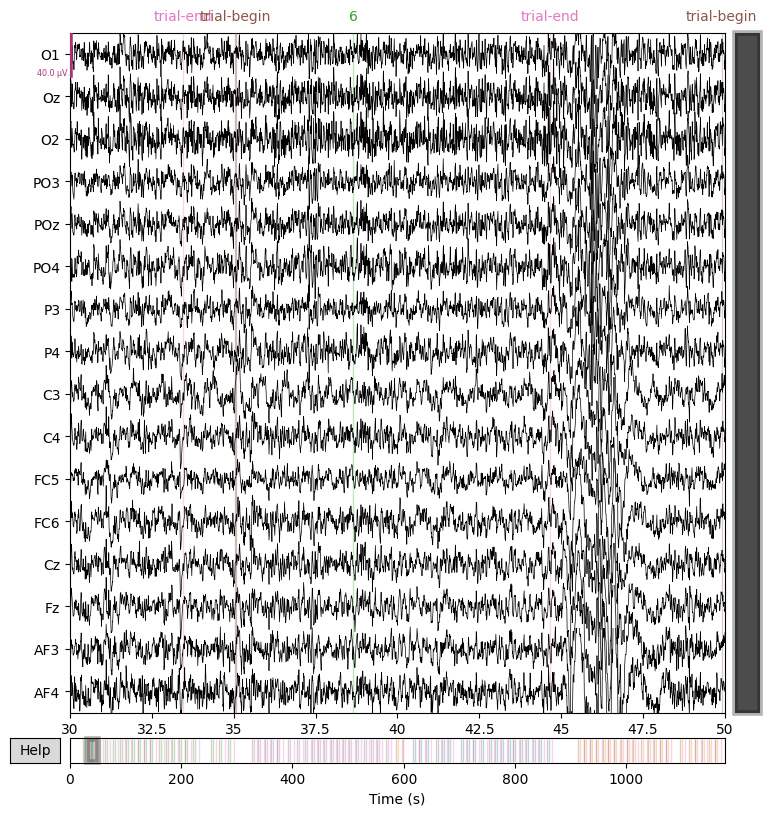

In [ ]:
plt = raw.plot(duration= 20, start=30,n_channels=len(raw.ch_names))

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.384 (s)
Plotting power spectral density (dB=True).


<ipython-input-11-c02e1051cca1>:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  plt = raw.plot_psd(fmax=60,tmin=0,tmax=820)


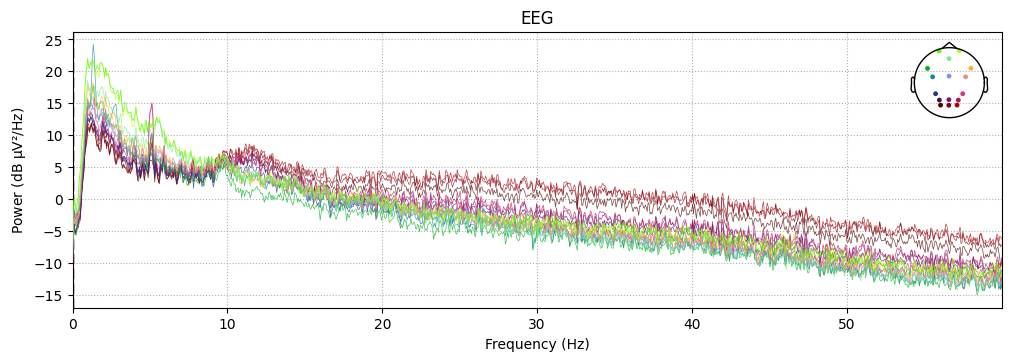

In [ ]:
plt = raw.plot_psd(fmax=60,tmin=0,tmax=820)

# ICA Analysis

In [ ]:
from mne.preprocessing import ICA
from mne_icalabel import label_components
from collections import Counter

In [ ]:
n_component = 16

## Raw

In [ ]:
ica_raw = ICA(
    n_components=n_component,
    max_iter="auto",
    method="infomax",
    random_state=97,
    fit_params=dict(extended=True),
)
ica_raw.fit(raw)
ica_raw

Fitting ICA to data using 16 channels (please be patient, this may take a while)


<ipython-input-14-13fdffca90bf>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica_raw.fit(raw)


Selecting by number: 16 components
Computing Extended Infomax ICA
Fitting ICA took 42.4s.


Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,140 iterations on raw data (147192 samples)
ICA components,16
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


In [ ]:
ic_labels_raw = label_components(raw, ica_raw, method="iclabel")
label_raw_cnt = Counter(ic_labels_raw["labels"])
label_raw_cnt

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<ipython-input-15-523f07e81f1e>:1: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels_raw = label_components(raw, ica_raw, method="iclabel")
<ipython-input-15-523f07e81f1e>:1: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels_raw = label_components(raw, ica_raw, method="iclabel")


Counter({'eye blink': 1, 'brain': 10, 'other': 4, 'heart beat': 1})

## Filtered

In [ ]:
raw_filtered = raw.copy()
raw_filtered.filter(2, 50)

ica_filtered = ICA(
    n_components=n_component,
    max_iter="auto",
    method="infomax",
    random_state=97,
    fit_params=dict(extended=True),
)
ica_filtered.fit(raw_filtered)
ica_filtered

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 207 samples (1.656 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 16 components
Computing Extended Infomax ICA
Fitting ICA took 51.0s.


Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,179 iterations on raw data (147192 samples)
ICA components,16
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


In [ ]:
ic_labels_filtered = label_components(raw_filtered, ica_filtered, method="iclabel")
label_filtered_cnt = Counter(ic_labels_filtered["labels"])
label_filtered_cnt

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<ipython-input-17-dcf562fff344>:1: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels_filtered = label_components(raw_filtered, ica_filtered, method="iclabel")
<ipython-input-17-dcf562fff344>:1: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels_filtered = label_components(raw_filtered, ica_filtered, method="iclabel")


Counter({'eye blink': 1, 'brain': 10, 'other': 2, 'heart beat': 3})

## ASR-corrected

In [ ]:
import asrpy

asr = asrpy.ASR(sfreq=raw.info["sfreq"], cutoff=20)
asr.fit(raw_filtered)
raw_asr = asr.transform(raw_filtered)

In [ ]:
ica_asr = ICA(
    n_components=n_component,
    max_iter="auto",
    method="infomax",
    random_state=97,
    fit_params=dict(extended=True),
)
ica_asr.fit(raw_asr)
ica_asr

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 16 components
Computing Extended Infomax ICA
Fitting ICA took 47.5s.


Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,500 iterations on raw data (147192 samples)
ICA components,16
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


In [ ]:
ic_labels_asr = label_components(raw_asr, ica_asr, method="iclabel")
label_asr_cnt = Counter(ic_labels_asr["labels"])
label_asr_cnt

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<ipython-input-20-9b6802b260ee>:1: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels_asr = label_components(raw_asr, ica_asr, method="iclabel")
<ipython-input-20-9b6802b260ee>:1: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels_asr = label_components(raw_asr, ica_asr, method="iclabel")


Counter({'brain': 12, 'eye blink': 1, 'heart beat': 2, 'other': 1})

In [ ]:
ic_labels_asr

{'y_pred_proba': array([0.90760183, 0.66198397, 0.43787146, 0.5133671 , 0.5052409 ,
        0.99699676, 0.42973247, 0.8562095 , 0.998897  , 0.9962528 ,
        0.6779511 , 0.7645498 , 0.82629967, 0.5866129 , 0.9192601 ,
        0.45787495], dtype=float32),
 'labels': ['brain',
  'eye blink',
  'brain',
  'heart beat',
  'brain',
  'brain',
  'heart beat',
  'brain',
  'brain',
  'brain',
  'brain',
  'brain',
  'brain',
  'other',
  'brain',
  'brain']}

## Result

In [ ]:
import pandas as pd

# 创建DataFrame
data = {
    'Pre-processing': ['raw', 'filtered', 'ASR-corrected'],
    'Brain': [label_raw_cnt['brain'], label_filtered_cnt['brain'], label_asr_cnt['brain']],
    'Muscle': [label_raw_cnt.get('muscle', 0), label_filtered_cnt.get('muscle', 0), label_asr_cnt.get('muscle', 0)],
    'Eye': [label_raw_cnt.get('eye blink', 0), label_filtered_cnt.get('eye blink', 0), label_asr_cnt.get('eye blink', 0)],
    'Heart': [label_raw_cnt.get('heart beat', 0), label_filtered_cnt.get('heart beat', 0), label_asr_cnt.get('heart beat', 0)],
    'Line Noise': [0, 0, 0],
    'Channel Noise': [0, 0, 0],
    'Other': [label_raw_cnt.get('other', 0), label_filtered_cnt.get('other', 0), label_asr_cnt.get('other', 0)]
}

df = pd.DataFrame(data)

display(df.set_index('Pre-processing'))

,Brain,Muscle,Eye,Heart,Line Noise,Channel Noise,Other
Pre-processing,,,,,,,
raw,10,0,1,1,0,0,4
filtered,10,0,1,3,0,0,2
ASR-corrected,12,0,1,2,0,0,1


<Figure size 1000x600 with 0 Axes>

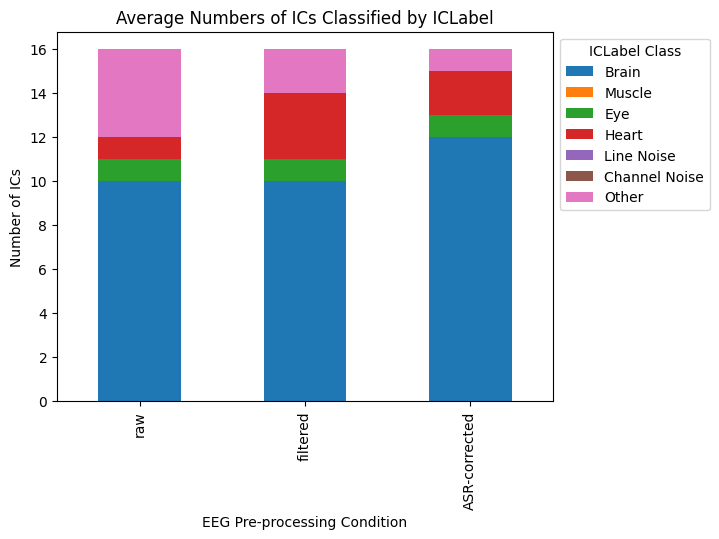

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

df.plot(x='Pre-processing', kind='bar', stacked=True, mark_right=True)
plt.title('Average Numbers of ICs Classified by ICLabel')
plt.ylabel('Number of ICs')
plt.xlabel('EEG Pre-processing Condition')
plt.legend(title='ICLabel Class', bbox_to_anchor=(1, 1))

plt.show()


# FBCCA

Reference Github: https://github.com/mnakanishi/TRCA-SSVEP

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 30 10:17:50 2019

@author: ALU

Steady-state visual evoked potentials (SSVEPs) detection using the filter
bank canonical correlation analysis (FBCCA)-based method [1].

function results = test_fbcca(eeg, list_freqs, fs, num_harms, num_fbs)

Input:
  eeg             : Input eeg data
                    (# of targets, # of channels, Data length [sample])
  list_freqs      : List for stimulus frequencies
  fs              : Sampling frequency
  num_harms       : # of harmonics
  num_fbs         : # of filters in filterbank analysis

Output:
  results         : The target estimated by this method

Reference:
  [1] X. Chen, Y. Wang, S. Gao, T. -P. Jung and X. Gao,
      "Filter bank canonical correlation analysis for implementing a
       high-speed SSVEP-based brain-computer interface",
      J. Neural Eng., vol.12, 046008, 2015.

"""
from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr
import warnings
import scipy.signal
import numpy as np


def filterbank(eeg, fs, idx_fb):
    if idx_fb == None:
        warnings.warn('stats:filterbank:MissingInput ' \
                      + 'Missing filter index. Default value (idx_fb = 0) will be used.')
        idx_fb = 0
    elif (idx_fb < 0 or 9 < idx_fb):
        raise ValueError('stats:filterbank:InvalidInput ' \
                         + 'The number of sub-bands must be 0 <= idx_fb <= 9.')

    if (len(eeg.shape) == 2):
        num_chans = eeg.shape[0]
        num_trials = 1
    else:
        num_chans, _, num_trials = eeg.shape

    # Nyquist Frequency = Fs/2N
    Nq = fs / 2

    passband = [6, 8, 10, 16, 22, 28, 34, 40]
    stopband = [4, 6,  6, 10, 16, 22, 28, 34]
    Wp = [passband[idx_fb] / Nq, 50 / Nq]
    Ws = [stopband[idx_fb] / Nq, 60 / Nq]
    [N, Wn] = scipy.signal.cheb1ord(Wp, Ws, 3, 40)  # band pass filter StopBand=[Ws(1)~Ws(2)] PassBand=[Wp(1)~Wp(2)]
    [B, A] = scipy.signal.cheby1(N, 0.5, Wn, 'bandpass')  # Wn passband edge frequency

    y = np.zeros(eeg.shape)
    if (num_trials == 1):
        for ch_i in range(num_chans):
            # apply filter, zero phass filtering by applying a linear filter twice, once forward and once backwards.
            # to match matlab result we need to change padding length
            y[ch_i, :] = scipy.signal.filtfilt(B, A, eeg[ch_i, :], padtype='odd', padlen=3 * (max(len(B), len(A)) - 1))

    else:
        for trial_i in range(num_trials):
            for ch_i in range(num_chans):
                y[ch_i, :, trial_i] = scipy.signal.filtfilt(B, A, eeg[ch_i, :, trial_i], padtype='odd',
                                                            padlen=3 * (max(len(B), len(A)) - 1))

    return y

def fbcca(data, list_freqs, fs, num_harms=3, num_fbs=5):

    fb_coefs = np.power(np.arange(1,num_fbs+1),(-1.25)) + 0.25

    num_targs = len(list_freqs)
    _, num_smpls = data.shape

    y_ref = cca_reference(list_freqs, fs, num_smpls, num_harms)
    cca = CCA(n_components=1) #initialize CCA

    # result matrix
    r = np.zeros((num_fbs,num_targs))

    for fb_i in range(num_fbs):  #filter bank number, deal with different filter bank
        testdata = filterbank(data, fs, fb_i)  #data after filtering
        for class_i in range(num_targs):
            refdata = np.squeeze(y_ref[class_i, :, :])   #pick corresponding freq target reference signal
            test_C, ref_C = cca.fit_transform(testdata.T, refdata.T)
            r_tmp, _ = pearsonr(np.squeeze(test_C), np.squeeze(ref_C)) #return r and p_value
            if r_tmp == np.nan:
                r_tmp=0
            r[fb_i, class_i] = r_tmp

    rho = np.dot(fb_coefs, r)  #weighted sum of r from all different filter banks' result
    print(rho) #print out the correlation
    result = np.argmax(rho)  #get maximum from the target as the final predict (get the index), and index indicates the maximum entry(most possible target)
    return result

'''
Generate reference signals for the canonical correlation analysis (CCA)
-based steady-state visual evoked potentials (SSVEPs) detection [1, 2].

function [ y_ref ] = cca_reference(listFreq, fs,  nSmpls, nHarms)

Input:
  listFreq        : List for stimulus frequencies
  fs              : Sampling frequency
  nSmpls          : # of samples in an epoch
  nHarms          : # of harmonics

Output:
  y_ref           : Generated reference signals
                   (# of targets, 2*# of channels, Data length [sample])

Reference:
  [1] Z. Lin, C. Zhang, W. Wu, and X. Gao,
      "Frequency Recognition Based on Canonical Correlation Analysis for
       SSVEP-Based BCI",
      IEEE Trans. Biomed. Eng., 54(6), 1172-1176, 2007.
  [2] G. Bin, X. Gao, Z. Yan, B. Hong, and S. Gao,
      "An online multi-channel SSVEP-based brain-computer interface using
       a canonical correlation analysis method",
      J. Neural Eng., 6 (2009) 046002 (6pp).
'''
def cca_reference(list_freqs, fs, num_smpls, num_harms=3):

    num_freqs = len(list_freqs)
    tidx = np.arange(1,num_smpls+1)/fs #time index

    y_ref = np.zeros((num_freqs, 2*num_harms, num_smpls))
    for freq_i in range(num_freqs):
        tmp = []
        for harm_i in range(1,num_harms+1):
            stim_freq = list_freqs[freq_i]  #in HZ
            # Sin and Cos
            tmp.extend([np.sin(2*np.pi*tidx*harm_i*stim_freq),
                       np.cos(2*np.pi*tidx*harm_i*stim_freq)])
        y_ref[freq_i] = tmp # 2*num_harms because include both sin and cos

    return y_ref

### Epoching

In [ ]:
events,all_events_id=mne.events_from_annotations(raw,event_id='auto')
# check event label
all_events_id

Used Annotations descriptions: ['10', '4.3', '6', '7.6', 'trial-begin', 'trial-end']


{'10': 1, '4.3': 2, '6': 3, '7.6': 4, 'trial-begin': 5, 'trial-end': 6}

In [ ]:
events_target = ['4.3', '6', '7.6', '10']

event_dict = {'4.3': 0, '6': 1, '7.6': 2, '10': 3}

# modify event id (before id, after id)
modify_dict = {
    2: 0, # 4.3
    3: 1, # 6
    4: 2, # 7.6
    1: 3 # 10
}

# create new_events: adjust label，modify target label, other event set as -1
new_events = events.copy()
idle_cnt = 0
for event in new_events:
  if event[2] in modify_dict:
    event[2] = modify_dict[event[2]]
  else:
    event[2] = -1

In [ ]:
picks = mne.pick_types(raw.info, eeg=True, stim=False, eog=False, exclude="bads")

reject_criteria = dict(
    eeg=0.0002 # 200 µV
)

## Filtered

In [ ]:
epochs_filtered = mne.Epochs(
    raw_filtered,
    new_events,
    event_id = event_dict,
    tmin = 0.5,
    tmax = 5.5,
    picks = picks,
    baseline = None,
    reject = reject_criteria,
    preload = True
)

Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 82 events and 627 original time points ...
    Rejecting  epoch based on EEG : ['AF3', 'AF4']
1 bad epochs dropped


In [ ]:
epochs_filtered

Number of events,81
Events,10: 204.3: 216: 207.6: 20
Time range,0.496 – 5.504 s
Baseline,off


In [ ]:
epochs_filtered.events[:,-1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
data_filtered = epochs_filtered.get_data(copy=True)
label_filtered = epochs_filtered.events[:,-1]
data_filtered.shape

(81, 16, 627)

In [ ]:
list_freqs = [4.3,6,7.6,10]

results = []
for i in range(len(data_filtered)):
  results.append(fbcca(data_filtered[i,:,:], list_freqs=list_freqs, fs = epochs_filtered.info['sfreq']))

results = np.array(results)
results

[0.91646436 1.22757459 1.17939534 1.31496332]
[0.86592128 1.20157629 1.06778162 1.5722264 ]
[1.03362298 1.04228019 1.20285471 1.54673475]
[0.95897738 1.26249431 1.16515701 1.19995752]
[0.85677225 1.47720504 1.11525439 1.11592799]
[1.09306127 1.10083984 1.18491049 1.21908277]
[0.87322701 1.02142964 1.20763695 1.34426782]
[0.93632324 1.19667265 1.15775979 1.30533208]
[0.85498274 1.21993113 1.38024068 1.33225401]
[0.97194531 1.36922891 1.31702341 1.29166317]
[1.05256818 1.22446843 1.26424026 1.31337087]
[0.97392462 1.32474254 1.08655952 1.20917155]
[1.02053291 1.30372689 1.05103112 1.30495093]
[1.08379938 1.16461276 1.26424248 1.40221948]
[1.09113201 1.41423159 0.98630436 1.16171615]
[0.8491862  1.27328638 1.41573344 1.30412848]
[0.88076296 1.11805909 1.23688718 1.02365019]
[0.86941684 1.05062692 1.0908362  1.04387416]
[0.96449002 1.19417126 1.2332368  1.17716299]
[0.93204755 1.15430326 1.13955524 1.171708  ]
[0.85618229 1.15525941 1.02290548 1.36475113]
[0.97183117 1.04148286 1.18646178 

array([3, 3, 3, 1, 1, 3, 3, 3, 2, 1, 3, 1, 3, 3, 1, 2, 2, 2, 2, 3, 3, 3,
       2, 3, 3, 3, 2, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 2, 1, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 0,
       1, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2])

In [ ]:
results.shape

(81,)

In [ ]:
correct_predictions = np.sum(label_filtered == results)
total_predictions = label_filtered.size

accuracy = correct_predictions / total_predictions
print(f"FBCCA Classification Accuracy: {accuracy:.2%}")

FBCCA Classification Accuracy: 30.86%


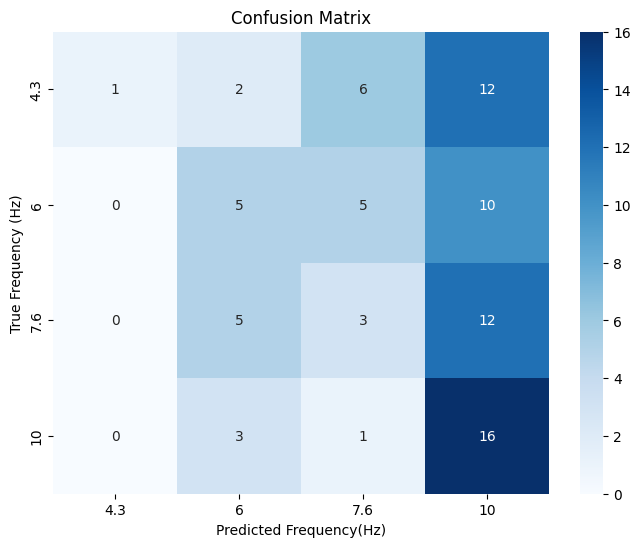

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# calculate confusion_matrix
cm = confusion_matrix(label_filtered, results)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_freqs, yticklabels=list_freqs)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Frequency(Hz)')
plt.ylabel('True Frequency (Hz)')
plt.show()

## Apply ASR

In [ ]:
epochs_asr = mne.Epochs(
    raw_asr,
    new_events,
    event_id = event_dict,
    tmin = 0.5,
    tmax = 5.5,
    picks = picks,
    baseline = None,
    reject = reject_criteria,
    preload = True
)

Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 82 events and 627 original time points ...
0 bad epochs dropped


In [ ]:
epochs_asr

Number of events,82
Events,10: 204.3: 226: 207.6: 20
Time range,0.496 – 5.504 s
Baseline,off


In [ ]:
epochs_asr.events[:,-1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
data_asr = epochs_asr.get_data(copy=True)
label_asr = epochs_asr.events[:,-1]
data_asr.shape

(82, 16, 627)

In [ ]:
#from FBCCA import fbcca
list_freqs = [4.3,6,7.6,10]

results = []
for i in range(len(data_asr)):
  results.append(fbcca(data_asr[i,:,:], list_freqs=list_freqs, fs = epochs_filtered.info['sfreq']))

results = np.array(results)
results

[0.91646436 1.22757459 1.17939534 1.31496332]
[0.86592128 1.20157629 1.06778162 1.5722264 ]
[1.03362298 1.04228019 1.20285471 1.54673475]
[0.95897738 1.26249431 1.16515701 1.19995752]
[0.85677225 1.47720504 1.11525439 1.11592799]
[1.09306127 1.10083984 1.18491049 1.21908277]
[0.87322701 1.02142964 1.20763695 1.34426782]
[0.93632324 1.19667265 1.15775979 1.30533208]
[0.85498274 1.21993113 1.38024068 1.33225401]
[0.97194531 1.36922891 1.31702341 1.29166317]
[1.05256818 1.22446843 1.26424026 1.31337087]
[0.97392462 1.32474254 1.08655952 1.20917155]
[1.02053291 1.30372689 1.05103112 1.30495093]
[1.08379938 1.16461276 1.26424248 1.40221948]
[1.09113201 1.41423159 0.98630436 1.16171615]
[0.8491862  1.27328638 1.41573344 1.30412848]
[0.88076296 1.11805909 1.23688718 1.02365019]
[0.86941684 1.05062692 1.0908362  1.04387416]
[0.96449002 1.19417126 1.2332368  1.17716299]
[0.93204755 1.15430326 1.13955524 1.171708  ]
[0.85618229 1.15525941 1.02290548 1.36475113]
[0.97183117 1.04148286 1.18646178 

array([3, 3, 3, 1, 1, 3, 3, 3, 2, 1, 3, 1, 3, 3, 1, 2, 2, 2, 2, 3, 3, 3,
       2, 3, 3, 3, 2, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 2, 2, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       0, 1, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2])

In [ ]:
results.shape

(82,)

In [ ]:
correct_predictions = np.sum(label_asr == results)
total_predictions = label_asr.size

accuracy = correct_predictions / total_predictions
print(f"FBCCA Classification Accuracy: {accuracy:.2%}")

FBCCA Classification Accuracy: 30.49%


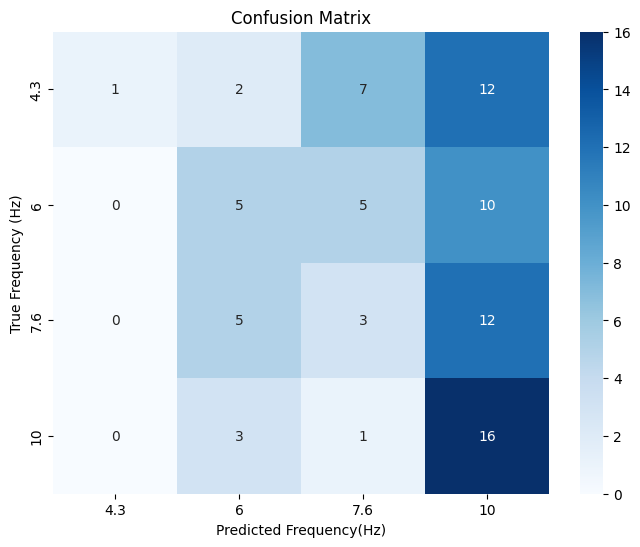

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# calculate confusion_matrix
cm = confusion_matrix(label_asr, results)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_freqs, yticklabels=list_freqs)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Frequency(Hz)')
plt.ylabel('True Frequency (Hz)')
plt.show()

# EEGnet

In [ ]:
import mne
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, DepthwiseConv2D
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, Input
from tensorflow.keras.constraints import max_norm


epochs_data = epochs_asr.get_data(copy=True)[:,:,:625]
epochs_data = np.transpose(epochs_data, (0, 2, 1))
epochs_data = np.expand_dims(epochs_data, axis=1)

labels = epochs_asr.events[:,-1]

# split data into train, val, test
X_train, X_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.2, random_state=37)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=37)

# segment 5 sec into 1 sec
def data_segmant(X, y):
  split_data = np.split(X, 5, axis=2)
  reshaped_data = np.concatenate(split_data, axis=0)

  repeated_labels = np.repeat(y, 5)
  return reshaped_data, repeated_labels

X_train, y_train = data_segmant(X_train, y_train)
X_val, y_val = data_segmant(X_val, y_val)
X_test, y_test = data_segmant(X_test, y_test)

# labal to one-hot code
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
y_test.shape

(85, 4)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense, Dropout, Flatten, ReLU, MaxPooling2D, Reshape, Permute

from tensorflow.keras.layers import Activation

def EEGNet(input_shape=(1, 125, 16)):
    inputs = Input(shape=input_shape)

    x = Conv2D(16, (1, 64), padding='valid', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = ReLU()(x)
    x = Permute((3, 2, 1))(x)

    x = tf.pad(x, paddings=tf.constant([[0, 0], [16, 17], [0, 1], [0, 0]]), mode="CONSTANT")
    x = Conv2D(4, (2, 32), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 4))(x)

    x = tf.pad(x, paddings=tf.constant([[0, 0], [2, 1], [4, 3], [0, 0]]), mode="CONSTANT")
    x = Conv2D(4, (8, 4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 4))(x)

    x = Flatten()(x)
    x = Dense(4)(x)  # Change the number of output units to 4 for 4 classes
    x = Activation('softmax')(x)  # Use softmax activation

    model = Model(inputs=inputs, outputs=x)
    return model

model = EEGNet()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_data=(X_val, y_val), verbose=2)

# evaluate model
scores = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {scores[1]}")


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1, 125, 16)]      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 1, 62, 16)         16384     
                                                                 
 batch_normalization_15 (Ba  (None, 1, 62, 16)         64        
 tchNormalization)                                               
                                                                 
 dropout_15 (Dropout)        (None, 1, 62, 16)         0         
                                                                 
 re_lu_15 (ReLU)             (None, 1, 62, 16)         0         
                                                                 
 permute_5 (Permute)         (None, 16, 62, 1)         0         
                                                           

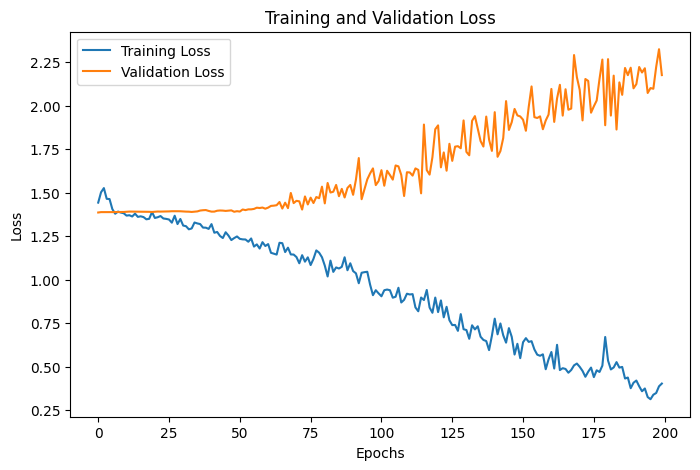

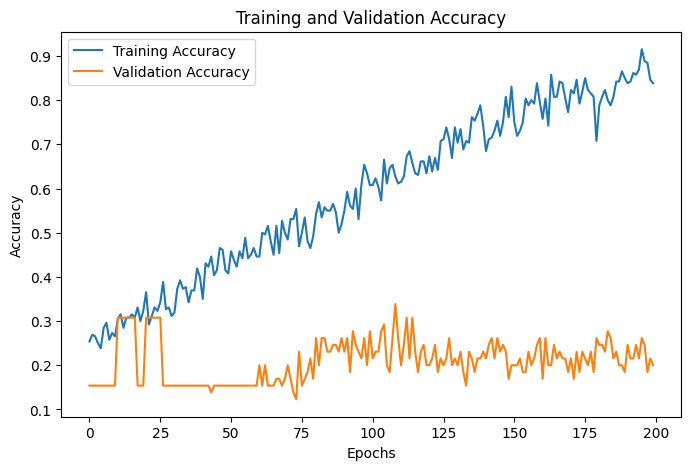

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3/3 [==============================] - 0s 7ms/step


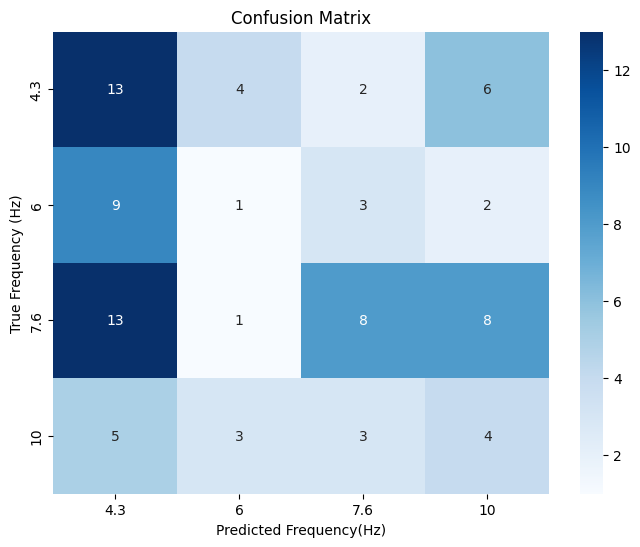

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

class_labels = [4.3, 6, 7.6, 10]

# calculate confusion_matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Frequency(Hz)')
plt.ylabel('True Frequency (Hz)')
plt.show()